### Part 0: Housekeeping

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#excel_path = "/content/drive/MyDrive/aggregateRockData.xlsx"
#categories_df = pd.read_excel(excel_path, usecols="A", nrows=480)
#categories_df.columns = ["Category"]

In [4]:
# Load the label data
## 2nd column: rock category number (1 = Igneous, 2 = Metamorphic, 3 = Sedimentary
labeldata = pd.read_excel("/content/drive/MyDrive/aggregateRockData.xlsx",
                          usecols=[1], nrows=480)
labeldata.rename(columns={labeldata.columns[0]: "Category"}, inplace=True)

# Load the feature data
feature_path = "/content/drive/MyDrive/feature_presence540.txt"
features_df = pd.read_csv(
    feature_path,
    sep=r"\s+",
    header=None,
    comment=None
)
features_df = features_df.iloc[:480, 2:14]
feature_names = [
    "Token number", "Angular fragments", "Rounded fragments",
    "Straight stripes", "Curved stripes", "Physical layers",
    "Veins", "Oily/shimmery texture", "Splotchy texture",
    "Single translucent crystal", "Multiple cubic crystals",
    "Sandy texture"
]
features_df.columns = feature_names

# Combine with categories
full_df = pd.concat([labeldata, features_df], axis=1)

### Part 1: Summary Stats

In [5]:
full_df.head()

,Category,Token number,Angular fragments,Rounded fragments,Straight stripes,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture
0,1,1,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10
1,1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05
2,1,3,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05
3,1,4,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10
4,1,5,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05


In [6]:
# Melt into long format
feature_cols = full_df.columns.difference(['Category', 'Token number'])
long_df = full_df.melt(value_vars=feature_cols, var_name='Feature', value_name='Value')

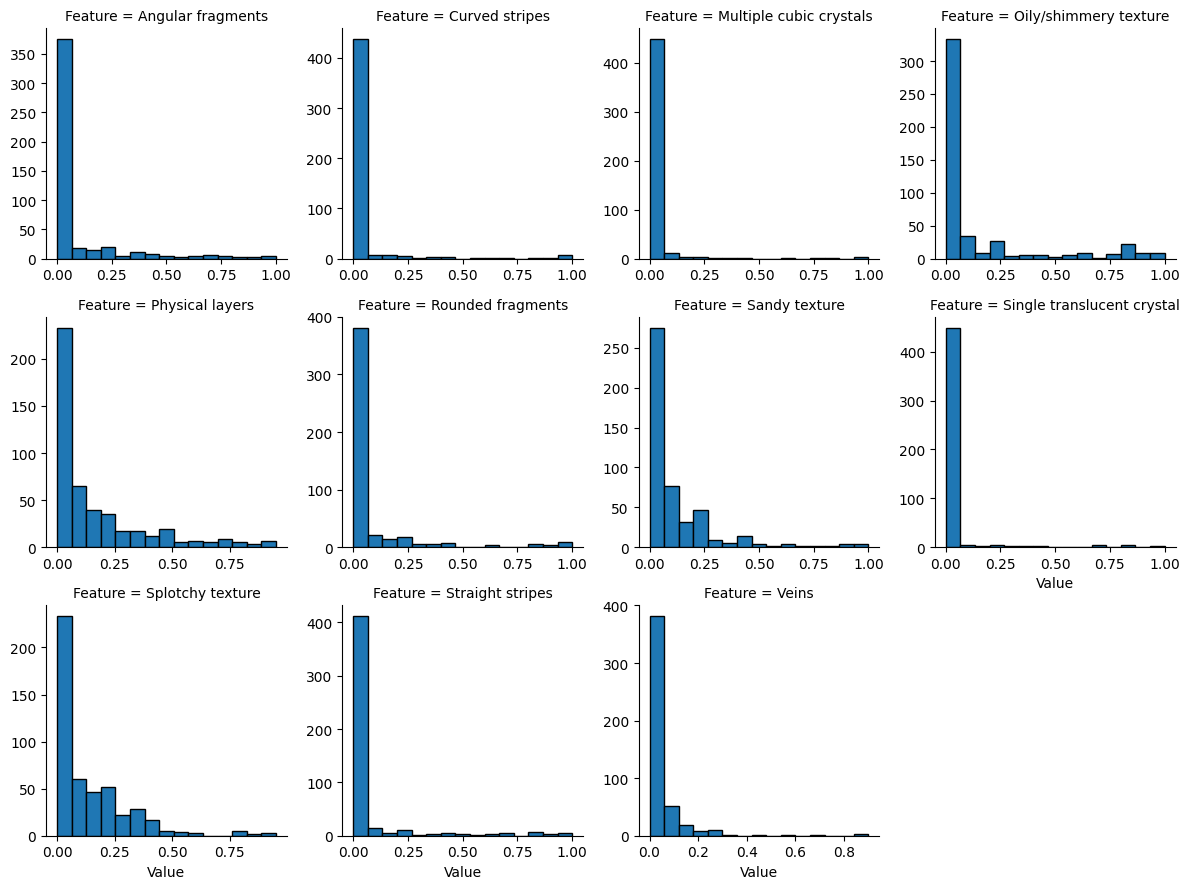

In [7]:
# Custom histogram plotting function
def conditional_custom_hist(data, **kwargs):
    ax = plt.gca()
    data = pd.Series(data).dropna().astype(float)
    plt.hist(data, bins=15, edgecolor='black')
    feature = kwargs.get('label')  # automatically passed by FacetGrid

    # Add custom x-ticks only to selected features
    if feature in ["Angular fragments", "Rounded fragments", "Straight stripes"]:
        min_val = data.min()
        median_val = data.median()
        max_val = data.max()
        ax.set_xticks([min_val, median_val, max_val])
        ax.set_xticklabels([f'{min_val:.2f}', f'{median_val:.2f}', f'{max_val:.2f}'])

# Create facet grid of histograms
g = sns.FacetGrid(long_df, col='Feature', col_wrap=4, sharex=False, sharey=False)
g.map(conditional_custom_hist, 'Value')

# Adjust layout and display
plt.tight_layout()
plt.show()

All of the features appear to be right skewed. I could go and transform all of them, but I don't think it is warranted. One, the range for all the features seem to range from 0 to 1. So, the magnitude isn't too extereme. Second, I don't think any of the models we will be using follow any assumptions about the normality of the predictors.

In [8]:
feature_summary = full_df.drop(columns=['Category', 'Token number']).describe()
feature_summary

,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


Yeah, pretty much just the same information that the histogram tells us.

### Part 2: Relationships

In [24]:
corrmat = full_df.drop(columns=['Category', 'Token number']).corr()
round(corrmat, 2)

,Angular fragments,Rounded fragments,Straight stripes,Curved stripes,Physical layers,Veins,Oily/shimmery texture,Splotchy texture,Single translucent crystal,Multiple cubic crystals,Sandy texture,Class
Angular fragments,1.00,0.25,-0.13,-0.10,-0.23,-0.12,-0.15,0.06,-0.09,-0.02,-0.17,-0.18
Rounded fragments,0.25,1.00,-0.12,-0.08,-0.24,-0.14,-0.14,0.01,-0.09,-0.04,-0.14,-0.03
Straight stripes,-0.13,-0.12,1.00,0.20,-0.03,0.04,-0.11,-0.14,-0.03,-0.07,0.11,0.09
Curved stripes,-0.10,-0.08,0.20,1.00,-0.13,0.05,-0.07,-0.12,-0.06,-0.06,-0.07,-0.02
Physical layers,-0.23,-0.24,-0.03,-0.13,1.00,0.06,0.18,-0.30,-0.10,-0.13,-0.04,0.31
Veins,-0.12,-0.14,0.04,0.05,0.06,1.00,-0.10,0.04,-0.01,-0.09,-0.05,0.13
Oily/shimmery texture,-0.15,-0.14,-0.11,-0.07,0.18,-0.10,1.00,-0.22,-0.02,-0.04,-0.32,-0.04
Splotchy texture,0.06,0.01,-0.14,-0.12,-0.30,0.04,-0.22,1.00,-0.07,-0.07,-0.17,-0.23
Single translucent crystal,-0.09,-0.09,-0.03,-0.06,-0.10,-0.01,-0.02,-0.07,1.00,0.12,-0.13,0.28
Multiple cubic crystals,-0.02,-0.04,-0.07,-0.06,-0.13,-0.09,-0.04,-0.07,0.12,1.00,-0.12,0.16


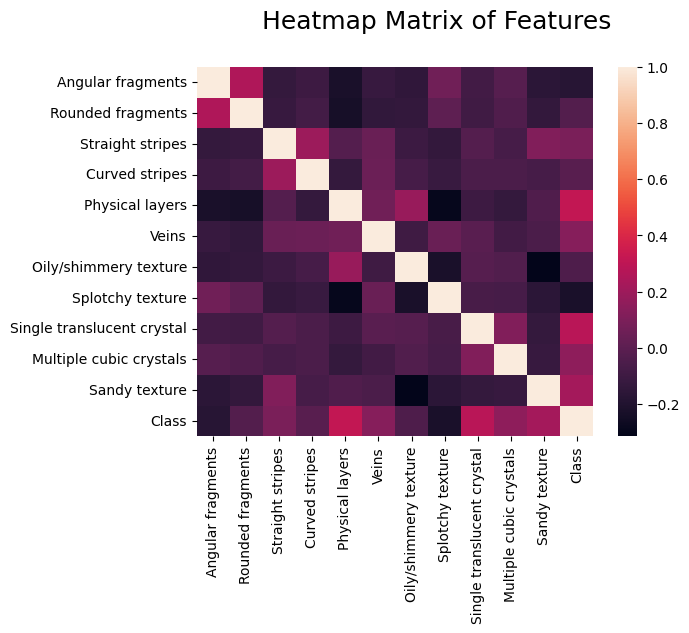

In [25]:
sns.heatmap(corrmat)
plt.suptitle("Heatmap Matrix of Features", y = 1, fontsize = 18)
plt.show()

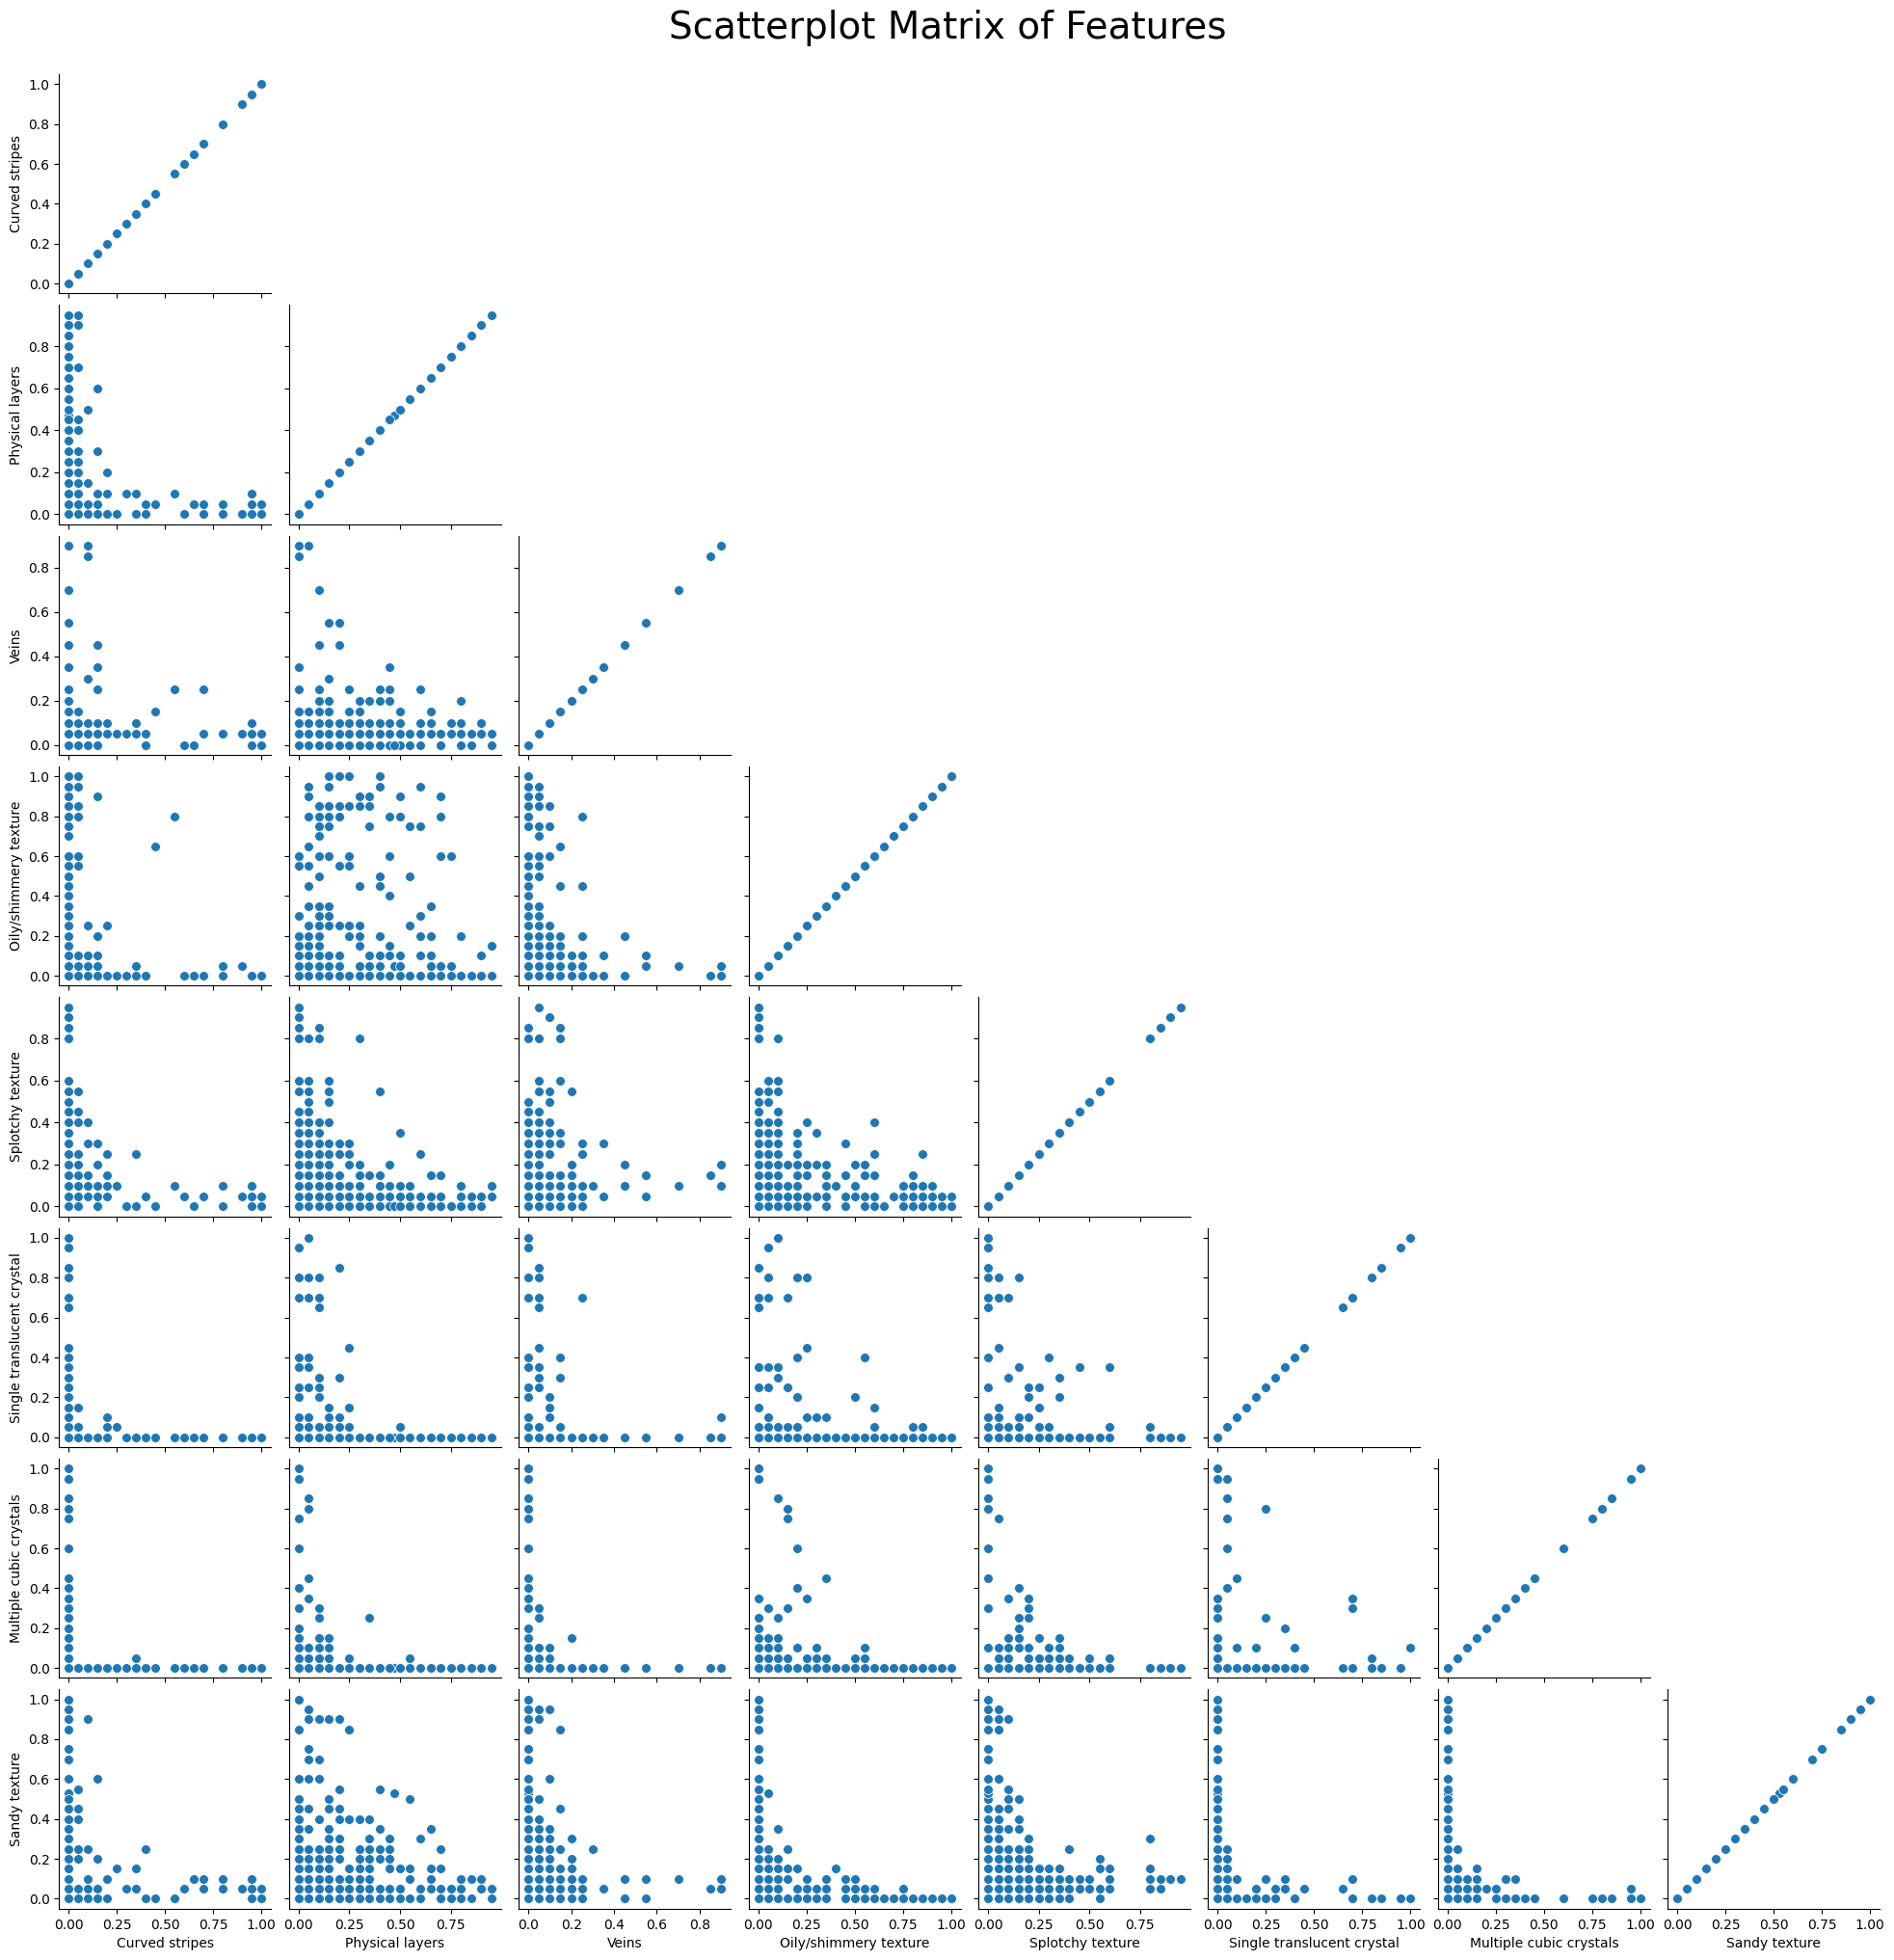

In [26]:
# Drops the categorical variables
features_only_df = full_df.drop(columns=["Category", "Token number"])

# Creates a scatterplot matrix of the remaining features
sns.pairplot(features_only_df, corner=True, diag_kind=None, plot_kws={'s': 50})
plt.suptitle("Scatterplot Matrix of Features", y=1.02, fontsize = 28)
plt.show()

All three matrices tell us the same story: there is little to no corrlation between the variables. This is a good thing, because we don't expect the features to be related at all.

### Part 3: Splitting the data

In [27]:
# Assign proper class labels for each rock subtype
# Each 16 rows belong to a different category (30 subtypes × 16 = 480 rows)
full_df['Class'] = (full_df.index // 16).astype(str)
full_df["Token number"] = full_df["Token number"].astype(int)
# creates empty lists for the different sets of the data
train_list, val_list, test_list = [], [], []

# loops through the data to fill the sets following what the description says
for _, group in full_df.groupby("Category"):
    group_sorted = group.sort_values("Token number")
    train_list.append(group_sorted[group_sorted["Token number"].between(1, 10)])
    val_list.append(group_sorted[group_sorted["Token number"].between(11, 13)])
    test_list.append(group_sorted[group_sorted["Token number"].between(14, 16)])

# Combine each list into a DataFrame
train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

# Verify the shapes
train_df.shape, val_df.shape, test_df.shape

((300, 14), (90, 14), (90, 14))

### Part 4: Classifiers

#### 4.1: Softmax Regression

In [28]:
# Prepare features and labels
X_train = train_df[feature_cols]
y_train = train_df['Category']
X_val = val_df[feature_cols]
y_val = val_df['Category']
X_test = test_df[feature_cols]
y_test = test_df['Category']

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

# Encode class labels
#le = LabelEncoder()
#y_train_enc = le.fit_transform(y_train)
#y_val_enc = le.transform(y_val)
#y_test_enc = le.transform(y_test)

# Train base multinomial logistic regression model
base_model = LogisticRegression(C = 1, solver='lbfgs', max_iter=1000)
base_model.fit(X_train, y_train)

# Predictions
y_train_pred = base_model.predict(X_train)
y_val_pred = base_model.predict(X_val)
y_test_pred = base_model.predict(X_test)

In [29]:
metrics = {
    "Set": ["Train", "Validation", "Test"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    "Precision": [
        precision_score(y_train, y_train_pred, average='macro', zero_division=0),
        precision_score(y_val, y_val_pred, average='macro', zero_division=0),
        precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "Recall": [
        recall_score(y_train, y_train_pred, average='macro', zero_division=0),
        recall_score(y_val, y_val_pred, average='macro', zero_division=0),
        recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "F1 Score": [
        f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    ]
}

metrics_df = pd.DataFrame(metrics)
metrics_df

,Set,Accuracy,Precision,Recall,F1 Score
0,Train,0.646667,0.646671,0.646667,0.646525
1,Validation,0.688889,0.696536,0.688889,0.682911
2,Test,0.700000,0.707468,0.700000,0.700304


In [30]:
solvers = ['lbfgs', 'newton-cg', 'sag', 'saga']
C_values = [0.01, 0.1, 1, 10, 100]
max_iter_values = [50, 100, 300, 500, 1000]

# Extend the grid search to include training and test metrics
extended_grid_results = []

for solver in solvers:
    for C in C_values:
        for max_iter in max_iter_values:
            try:
                model = LogisticRegression(C=C, solver=solver, max_iter=max_iter)
                model.fit(X_train, y_train)

                # Validation prediction
                y_val_pred = model.predict(X_val)
                # Training prediction
                y_train_pred = model.predict(X_train)
                # Test prediction
                y_test_pred = model.predict(X_test)

                extended_grid_results.append({
                    "Solver": solver,
                    "C": C,
                    "max_iter": max_iter,

                    # Validation metrics
                    "Val Accuracy": accuracy_score(y_val, y_val_pred),
                    "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                    "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                    "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),

                    # Train metrics
                    "Train Accuracy": accuracy_score(y_train, y_train_pred),
                    "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                    "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                    "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),

                    # Test metrics
                    "Test Accuracy": accuracy_score(y_test, y_test_pred),
                    "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                    "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                    "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                })
            except Exception as e:
                extended_grid_results.append({
                    "Solver": solver,
                    "C": C,
                    "max_iter": max_iter,
                    "Val Accuracy": None,
                    "Val Precision": None,
                    "Val Recall": None,
                    "Val F1": None,
                    "Train Accuracy": None,
                    "Train Precision": None,
                    "Train Recall": None,
                    "Train F1": None,
                    "Test Accuracy": None,
                    "Test Precision": None,
                    "Test Recall": None,
                    "Test F1": None,
                    "Error": str(e)
                })

# Create and display DataFrame
extended_df = pd.DataFrame(extended_grid_results).round(2)
extended_df.head()


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef

,Solver,C,max_iter,Val Accuracy,Val Precision,Val Recall,Val F1,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
0,lbfgs,0.01,50,0.62,0.63,0.62,0.61,0.59,0.59,0.59,0.58,0.62,0.62,0.62,0.62
1,lbfgs,0.01,100,0.62,0.63,0.62,0.61,0.59,0.59,0.59,0.58,0.62,0.62,0.62,0.62
2,lbfgs,0.01,300,0.62,0.63,0.62,0.61,0.59,0.59,0.59,0.58,0.62,0.62,0.62,0.62
3,lbfgs,0.01,500,0.62,0.63,0.62,0.61,0.59,0.59,0.59,0.58,0.62,0.62,0.62,0.62
4,lbfgs,0.01,1000,0.62,0.63,0.62,0.61,0.59,0.59,0.59,0.58,0.62,0.62,0.62,0.62


Since we have 30 different classes of rocks, there is a greater risk of misclassification. This means that using a metric like accuracy can be misleading (not looking at *which* classes softmax is getting right). We can balance both precision and recall using the F1 score - since it is the harmonic mean of the two metrics. Identifying the best iterations based on the F1 score can be found below:

In [31]:
# Identify the best performing row for each set based on F1 Score
best_train = extended_df.loc[extended_df["Train F1"].idxmax()]
best_val = extended_df.loc[extended_df["Val F1"].idxmax()]
best_test = extended_df.loc[extended_df["Test F1"].idxmax()]

# Combine into one summary DataFrame
best_combinations = pd.DataFrame([best_train, best_val, best_test])
best_combinations.index = ["Best on Train", "Best on Validation", "Best on Test"]
best_combinations

,Solver,C,max_iter,Val Accuracy,Val Precision,Val Recall,Val F1,Train Accuracy,Train Precision,Train Recall,Train F1,Test Accuracy,Test Precision,Test Recall,Test F1
Best on Train,lbfgs,100.0,50,0.76,0.76,0.76,0.75,0.67,0.67,0.67,0.67,0.68,0.68,0.68,0.68
Best on Validation,lbfgs,10.0,50,0.76,0.76,0.76,0.75,0.65,0.65,0.65,0.65,0.72,0.73,0.72,0.72
Best on Test,lbfgs,10.0,50,0.76,0.76,0.76,0.75,0.65,0.65,0.65,0.65,0.72,0.73,0.72,0.72


In [32]:
best_val = extended_df.loc[extended_df["Val F1"].idxmax()]
print("Best LR configuration based on Validation F1 Score:")
print(best_val[['Solver', 'C', 'max_iter', 'Val F1']])

# best rl model
best_lr_model = LogisticRegression(
    C=best_val["C"],
    solver=best_val["Solver"],
    max_iter=int(best_val["max_iter"])
)

best_lr_model.fit(X_train, y_train)

best_val = extended_df.loc[extended_df["Val F1"].idxmax()]
print("Best LR configuration based on Validation F1 Score:")
print(best_val[['Solver', 'C', 'max_iter', 'Val F1']])

# best rl model
best_lr_model = LogisticRegression(
    C=best_val["C"],
    solver=best_val["Solver"],
    max_iter=int(best_val["max_iter"])
)

best_lr_model.fit(X_train, y_train)

# performance
y_val_pred_best_lr = best_lr_model.predict(X_val)
print("\nBest LR Model Validation Accuracy: {:.2f}".format(accuracy_score(y_val, y_val_pred_best_lr)))

Best LR configuration based on Validation F1 Score:
Solver      lbfgs
C            10.0
max_iter       50
Val F1       0.75
Name: 15, dtype: object
Best LR configuration based on Validation F1 Score:
Solver      lbfgs
C            10.0
max_iter       50
Val F1       0.75
Name: 15, dtype: object

Best LR Model Validation Accuracy: 0.76


#### 4.2: Support Vector Machine

In [112]:
# 0. Setup
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import GridSearchCV

X_train = train_df[feature_cols]
y_train = train_df['Category']
X_val = val_df[feature_cols]
y_val = val_df['Category']
X_test = test_df[feature_cols]
y_test = test_df['Category']

## data shapes
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

## scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# 1. Train the baseline SVM model 2pts
## Initialize the SVM model
svm_model = SVC()

## Fit on the training data
svm_model.fit(X_train_scaled, y_train)

## Measure Baseline Performance
y_train_pred = svm_model.predict(X_train_scaled,)
y_val_pred = svm_model.predict(X_val_scaled,)
y_test_pred = svm_model.predict(X_test_scaled,)

metrics_svm = {
    "Set": ["Train", "Validation", "Test"],
    "Accuracy": [
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_test, y_test_pred)
    ],
    "Precision": [
        precision_score(y_train, y_train_pred, average='macro', zero_division=0),
        precision_score(y_val, y_val_pred, average='macro', zero_division=0),
        precision_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "Recall": [
        recall_score(y_train, y_train_pred, average='macro', zero_division=0),
        recall_score(y_val, y_val_pred, average='macro', zero_division=0),
        recall_score(y_test, y_test_pred, average='macro', zero_division=0)
    ],
    "F1 Score": [
        f1_score(y_train, y_train_pred, average='macro', zero_division=0),
        f1_score(y_val, y_val_pred, average='macro', zero_division=0),
        f1_score(y_test, y_test_pred, average='macro', zero_division=0)
    ]
}

metrics_svm_df = pd.DataFrame(metrics_svm)
metrics_svm_df

# 2. Hyperparameter Tuning 3pts
## set Up the Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': [2, 3, 4], # Only used for 'poly'
    "gamma": ["scale", "auto", 0.1, 1],
}

# Method 1: GridSearchCV
#grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
## Fit on the training data
#grid_search.fit(X_train_scaled, y_train)
## Print the best parameters
#print("Best parameters found:", grid_search.best_params_)
## Best estimator from grid search
#best_svm = grid_search.best_estimator_

# Method 2: manual grid search
C_values = [0.1, 1, 10, 100]
kernels = ['linear', 'poly', 'rbf']
gamma_values = ["scale", "auto", 0.1, 1]
degrees = [2, 3, 4]  # Only used when kernel is 'poly'

## List to store the results
svm_grid_results = []

for C in C_values:
    for kernel in kernels:
        for gamma in gamma_values:
            # For 'poly' kernel, iterate over degree values.
            if kernel == 'poly':
                for degree in degrees:
                    try:
                        # Initialize and train the model with degree parameter
                        model = SVC(C=C, kernel=kernel, gamma=gamma, degree=degree)
                        model.fit(X_train_scaled, y_train)

                        # Generate predictions on scaled data
                        y_train_pred = model.predict(X_train_scaled)
                        y_val_pred   = model.predict(X_val_scaled)
                        y_test_pred  = model.predict(X_test_scaled)

                        # Record performance metrics
                        svm_grid_results.append({
                            "C": C,
                            "kernel": kernel,
                            "gamma": gamma,
                            "degree": degree,
                            "Train Accuracy": accuracy_score(y_train, y_train_pred),
                            "Val Accuracy": accuracy_score(y_val, y_val_pred),
                            "Test Accuracy": accuracy_score(y_test, y_test_pred),
                            "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                            "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                            "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                            "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                        })
                    except Exception as e:
                        svm_grid_results.append({
                            "C": C,
                            "kernel": kernel,
                            "gamma": gamma,
                            "degree": degree,
                            "Error": str(e)
                        })
            else:
                try:
                    # Initialize and train the model without the degree parameter
                    model = SVC(C=C, kernel=kernel, gamma=gamma)
                    model.fit(X_train_scaled, y_train)

                    # Generate predictions on scaled data
                    y_train_pred = model.predict(X_train_scaled)
                    y_val_pred   = model.predict(X_val_scaled)
                    y_test_pred  = model.predict(X_test_scaled)

                    # Record performance metrics; degree is not applicable
                    svm_grid_results.append({
                        "C": C,
                        "kernel": kernel,
                        "gamma": gamma,
                        "degree": None,
                        "Train Accuracy": accuracy_score(y_train, y_train_pred),
                        "Val Accuracy": accuracy_score(y_val, y_val_pred),
                        "Test Accuracy": accuracy_score(y_test, y_test_pred),
                        "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                    })
                except Exception as e:
                    svm_grid_results.append({
                        "C": C,
                        "kernel": kernel,
                        "gamma": gamma,
                        "degree": None,
                        "Error": str(e)
                    })

## Create a DataFrame to display the results
svm_grid_df = pd.DataFrame(svm_grid_results).round(2)
print(svm_grid_df.head())
# 3. Evaluation
if not svm_grid_df.empty and svm_grid_df['Val F1'].notnull().any():
    # Find the row with the highest validation accuracy
    best_result = svm_grid_df.loc[svm_grid_df["Val F1"].idxmax()]
    best_params = {
        "C": best_result["C"],
        "kernel": best_result["kernel"],
        "gamma": best_result["gamma"],
        "degree": best_result["degree"]
    }

    print("Best configuration based on Validation F1:")
    print(best_params)
    print("\nPerformance Metrics for this configuration:")
    print(best_result[['Train Accuracy', 'Val Accuracy', 'Test Accuracy',
                       'Train Precision', 'Val Precision', 'Test Precision',
                       'Train Recall', 'Val Recall', 'Test Recall',
                       'Train F1', 'Val F1', 'Test F1']])
else:
    print("No valid configuration found.")

Training set shape: (300, 11)
Validation set shape: (90, 11)
Test set shape: (90, 11)
     C  kernel  gamma  degree  Train Accuracy  Val Accuracy  Test Accuracy  \
0  0.1  linear  scale     NaN            0.67          0.74           0.68   
1  0.1  linear   auto     NaN            0.67          0.74           0.68   
2  0.1  linear    0.1     NaN            0.67          0.74           0.68   
3  0.1  linear      1     NaN            0.67          0.74           0.68   
4  0.1    poly  scale     2.0            0.56          0.61           0.62   

   Train Precision  Val Precision  Test Precision  Train Recall  Val Recall  \
0             0.67           0.74            0.68          0.67        0.74   
1             0.67           0.74            0.68          0.67        0.74   
2             0.67           0.74            0.68          0.67        0.74   
3             0.67           0.74            0.68          0.67        0.74   
4             0.69           0.78            0.74 

In [113]:
# 4. report the best performance for train, val, and test data. 3pts
# Identify the best-performing hyperparameters based on F1 Score for each dataset
best_train = svm_grid_df.loc[svm_grid_df["Train F1"].idxmax()]
best_val = svm_grid_df.loc[svm_grid_df["Val F1"].idxmax()]
best_test = svm_grid_df.loc[svm_grid_df["Test F1"].idxmax()]

# Combine results into a clearly formatted summary DataFrame
best_combinations = pd.DataFrame([best_train, best_val, best_test])

# Label the rows clearly
best_combinations.index = ["Best on Train", "Best on Validation", "Best on Test"]

# Display the summary DataFrame
best_combinations

,C,kernel,gamma,degree,Train Accuracy,Val Accuracy,Test Accuracy,Train Precision,Val Precision,Test Precision,Train Recall,Val Recall,Test Recall,Train F1,Val F1,Test F1
Best on Train,10.0,poly,1,4.0,1.00,0.61,0.59,1.00,0.61,0.59,1.00,0.61,0.59,1.00,0.61,0.59
Best on Validation,10.0,rbf,scale,NaN,0.81,0.79,0.61,0.81,0.79,0.61,0.81,0.79,0.61,0.81,0.79,0.61
Best on Test,100.0,poly,1,2.0,0.90,0.62,0.74,0.90,0.62,0.75,0.90,0.62,0.74,0.90,0.62,0.74


In [107]:
# 4. Discussion 2pts
'''
The baseline model, with default settings, achieved 67% training accuracy,
74% validation accuracy, and 68% test accuracy, indicating room for improvement.

After a manual grid search, the best configuration found was C = 10,
Kernel = Polynomial, Gamma = 0.1, Degree = 3.
This setup increased validation accuracy to 79% and test accuracy to 71%,
showing better generalization. The polynomial kernel outperformed linear and RBF,
likely due to its ability to capture complex decision boundaries.

Higher C (10) improved training classification without overfitting,
while Gamma (0.1) controlled sensitivity to data points.
The validation accuracy closely matched test accuracy,
confirming the model’s ability to generalize.

In summary, tuning C, kernel type, gamma,
and degree boosted test accuracy from 68% to 71%,
demonstrating the importance of careful hyperparameter selection for improved predictive performance.
'''

'\nThe baseline model, with default settings, achieved 67% training accuracy, \n74% validation accuracy, and 68% test accuracy, indicating room for improvement.\n\nAfter a manual grid search, the best configuration found was C = 10, \nKernel = Polynomial, Gamma = 0.1, Degree = 3. \nThis setup increased validation accuracy to 79% and test accuracy to 71%, \nshowing better generalization. The polynomial kernel outperformed linear and RBF, \nlikely due to its ability to capture complex decision boundaries.\n\nHigher C (10) improved training classification without overfitting, \nwhile Gamma (0.1) controlled sensitivity to data points. \nThe validation accuracy closely matched test accuracy, \nconfirming the model’s ability to generalize.\n\nIn summary, tuning C, kernel type, gamma, \nand degree boosted test accuracy from 68% to 71%, \ndemonstrating the importance of careful hyperparameter selection for improved predictive performance.\n'

In [108]:
if not svm_grid_df.empty and svm_grid_df["Val F1"].notnull().any():
    best_result = svm_grid_df.loc[svm_grid_df["Val F1"].idxmax()]
    best_params = {
         "C": best_result["C"],
         "kernel": best_result["kernel"],
         "gamma": best_result["gamma"],
         "degree": best_result["degree"]
    }
    print("Best SVM configuration based on Validation F1:")
    print(best_params)

    # Define the best SVM model using these parameters
    if best_params["kernel"] == "poly":
         best_svm_model = SVC(
             C=best_params["C"],
             kernel=best_params["kernel"],
             gamma=best_params["gamma"],
             degree=int(best_params["degree"])  # Ensure degree is an integer
         )
    else:
         best_svm_model = SVC(
             C=best_params["C"],
             kernel=best_params["kernel"],
             gamma=best_params["gamma"]
         )
    best_svm_model.fit(X_train_scaled, y_train)
else:
    print("No valid SVM configuration found.")

Best SVM configuration based on Validation F1:
{'C': np.float64(10.0), 'kernel': 'rbf', 'gamma': 'scale', 'degree': np.float64(nan)}


#### 4.3: Random Forest classifier  

In [111]:
# 0. Setup
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

X_train = train_df[feature_cols]
y_train = train_df['Category']
X_val = val_df[feature_cols]
y_val = val_df['Category']
X_test = test_df[feature_cols]
y_test = test_df['Category']

# 1. Train the Baseline Model 2pts
baseline_rf = RandomForestClassifier(random_state=42)
baseline_rf.fit(X_train, y_train)

# Predictions with the baseline model
y_train_pred_baseline = baseline_rf.predict(X_train)
y_val_pred_baseline = baseline_rf.predict(X_val)
y_test_pred_baseline = baseline_rf.predict(X_test)

# Compute performance metrics for the baseline model
baseline_metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_baseline),
    "Val Accuracy": accuracy_score(y_val, y_val_pred_baseline),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_baseline),
    "Train Precision": precision_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val Precision": precision_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test Precision": precision_score(y_test, y_test_pred_baseline, average='macro', zero_division=0),
    "Train Recall": recall_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val Recall": recall_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test Recall": recall_score(y_test, y_test_pred_baseline, average='macro', zero_division=0),
    "Train F1": f1_score(y_train, y_train_pred_baseline, average='macro', zero_division=0),
    "Val F1": f1_score(y_val, y_val_pred_baseline, average='macro', zero_division=0),
    "Test F1": f1_score(y_test, y_test_pred_baseline, average='macro', zero_division=0)
}
print("Baseline Random Forest Performance:")
print(pd.DataFrame(baseline_metrics, index=[0]))

# 2. Hyperparameter Tuning (Manual Grid Search) 3pts
# set Up the Hyperparameter Grid
n_estimators_values = [50, 100, 200]  # number of trees
max_depth_values = [None, 10, 20, 30] # maximum depth of the tree; None means no limit
min_samples_split_values = [2, 5, 10] # minimum number of samples required to split an internal node
min_samples_leaf_values = [1, 2, 4]   # minimum number of samples required to be at a leaf node

rf_grid_results = []

# Iterate over all combinations of hyperparameters
for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
            for min_samples_leaf in min_samples_leaf_values:
                try:
                    model = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    model.fit(X_train, y_train)

                    # Predictions for each split
                    y_train_pred = model.predict(X_train)
                    y_val_pred = model.predict(X_val)
                    y_test_pred = model.predict(X_test)

                    rf_grid_results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_split": min_samples_split,
                        "min_samples_leaf": min_samples_leaf,
                        "Train Accuracy": accuracy_score(y_train, y_train_pred),
                        "Val Accuracy": accuracy_score(y_val, y_val_pred),
                        "Test Accuracy": accuracy_score(y_test, y_test_pred),
                        "Train Precision": precision_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Precision": precision_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Precision": precision_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train Recall": recall_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val Recall": recall_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test Recall": recall_score(y_test, y_test_pred, average='macro', zero_division=0),
                        "Train F1": f1_score(y_train, y_train_pred, average='macro', zero_division=0),
                        "Val F1": f1_score(y_val, y_val_pred, average='macro', zero_division=0),
                        "Test F1": f1_score(y_test, y_test_pred, average='macro', zero_division=0)
                    })
                except Exception as e:
                    rf_grid_results.append({
                        "n_estimators": n_estimators,
                        "max_depth": max_depth,
                        "min_samples_split": min_samples_split,
                        "min_samples_leaf": min_samples_leaf,
                        "Error": str(e)
                    })

# Create a DataFrame with the grid search results
rf_grid_df = pd.DataFrame(rf_grid_results)
print("\nHyperparameter Tuning Results (first 5 rows):")
print(rf_grid_df.head())

# Extract the best configuration based on highest validation F1
if not rf_grid_df.empty and rf_grid_df['Val F1'].notnull().any():
    best_idx = rf_grid_df['Val F1'].idxmax()
    best_rf_config = rf_grid_df.loc[best_idx]
    print("\nBest Configuration based on Validation F1:")
    print(best_rf_config)
else:
    print("No valid configuration found.")

# 3. Evaluation of the Best Model
# Train the best Random Forest model using the best hyperparameters
best_rf_model = RandomForestClassifier(
    n_estimators=int(best_rf_config['n_estimators']),
    max_depth=(int(best_rf_config['max_depth']) if pd.notnull(best_rf_config['max_depth']) else None), # Convert to int if not None
    min_samples_split=int(best_rf_config['min_samples_split']),
    min_samples_leaf=int(best_rf_config['min_samples_leaf']),
    random_state=42
)
best_rf_model.fit(X_train, y_train)

# Predictions for the best model
y_train_pred_best = best_rf_model.predict(X_train)
y_val_pred_best = best_rf_model.predict(X_val)
y_test_pred_best = best_rf_model.predict(X_test)

# Compute evaluation metrics
evaluation_metrics = {
    "Train Accuracy": accuracy_score(y_train, y_train_pred_best),
    "Val Accuracy": accuracy_score(y_val, y_val_pred_best),
    "Test Accuracy": accuracy_score(y_test, y_test_pred_best),
    "Train Precision": precision_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val Precision": precision_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test Precision": precision_score(y_test, y_test_pred_best, average='macro', zero_division=0),
    "Train Recall": recall_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val Recall": recall_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test Recall": recall_score(y_test, y_test_pred_best, average='macro', zero_division=0),
    "Train F1": f1_score(y_train, y_train_pred_best, average='macro', zero_division=0),
    "Val F1": f1_score(y_val, y_val_pred_best, average='macro', zero_division=0),
    "Test F1": f1_score(y_test, y_test_pred_best, average='macro', zero_division=0)
}
print("\nEvaluation Metrics for the Best Random Forest Model:")
print(pd.DataFrame(evaluation_metrics, index=[0]))

Baseline Random Forest Performance:
   Train Accuracy  Val Accuracy  Test Accuracy  Train Precision  \
0             1.0      0.755556       0.677778              1.0   

   Val Precision  Test Precision  Train Recall  Val Recall  Test Recall  \
0       0.757179        0.679691           1.0    0.755556     0.677778   

   Train F1    Val F1   Test F1  
0       1.0  0.753182  0.677901  

Hyperparameter Tuning Results (first 5 rows):
   n_estimators  max_depth  min_samples_split  min_samples_leaf  \
0            50        NaN                  2                 1   
1            50        NaN                  2                 2   
2            50        NaN                  2                 4   
3            50        NaN                  5                 1   
4            50        NaN                  5                 2   

   Train Accuracy  Val Accuracy  Test Accuracy  Train Precision  \
0        0.996667      0.722222       0.688889         0.996700   
1        0.936667      0.7

In [109]:
# 4. report the best performance for train, val, and test data. 3pts
# Identify the best-performing Random Forest hyperparameters based on F1 Score
best_train_rf = rf_grid_df.loc[rf_grid_df["Train F1"].idxmax()]
best_val_rf = rf_grid_df.loc[rf_grid_df["Val F1"].idxmax()]
best_test_rf = rf_grid_df.loc[rf_grid_df["Test F1"].idxmax()]

# Combine these results into one clear summary DataFrame
best_rf_combinations = pd.DataFrame([best_train_rf, best_val_rf, best_test_rf])

# Clearly label the rows
best_rf_combinations.index = ["Best on Train", "Best on Validation", "Best on Test"]

# Display the summary DataFrame
best_rf_combinations

,n_estimators,max_depth,min_samples_split,min_samples_leaf,Train Accuracy,Val Accuracy,Test Accuracy,Train Precision,Val Precision,Test Precision,Train Recall,Val Recall,Test Recall,Train F1,Val F1,Test F1
Best on Train,100.0,NaN,2.0,1.0,1.000000,0.755556,0.677778,1.000000,0.757179,0.679691,1.000000,0.755556,0.677778,1.000000,0.753182,0.677901
Best on Validation,100.0,10.0,10.0,1.0,0.886667,0.800000,0.700000,0.887375,0.798319,0.699394,0.886667,0.800000,0.700000,0.886732,0.797414,0.699571
Best on Test,100.0,10.0,5.0,2.0,0.913333,0.788889,0.744444,0.914220,0.788272,0.744444,0.913333,0.788889,0.744444,0.913230,0.785869,0.743888


In [110]:
# 5. Discussion 2pts
'''
For hyperparameter optimization, the hyperparameters of the Random Forest classifier
i.e., number of trees (n_estimators), maximum tree depth (max_depth),
minimum samples to split a node (min_samples_split),
and minimum samples at every leaf node (min_samples_leaf)—were systematically altered.
Initially, the baseline model, under default settings,
showed very high accuracy on training data (100%)
but relatively lower validation accuracy (75.6%), which indicated overfitting.

By limiting tree depth (max_depth=10) and
increasing the minimum number of samples required to split nodes (min_samples_split=10),
model complexity was reduced,
which created a more acceptable trade-off between training accuracy (88.7%) and
validation accuracy (80.0%). This optimal set of hyperparameters improved generalization,
as represented by higher validation and test accuracies compared to the baseline.
Therefore, careful tuning of hyperparameters can avoid overfitting and
enhance the model’s predictive accuracy on unseen data.
'''

'\nFor hyperparameter optimization, the hyperparameters of the Random Forest classifier\ni.e., number of trees (n_estimators), maximum tree depth (max_depth), \nminimum samples to split a node (min_samples_split), \nand minimum samples at every leaf node (min_samples_leaf)—were systematically altered. \nInitially, the baseline model, under default settings, \nshowed very high accuracy on training data (100%) \nbut relatively lower validation accuracy (75.6%), which indicated overfitting.\n\nBy limiting tree depth (max_depth=10) and \nincreasing the minimum number of samples required to split nodes (min_samples_split=10), \nmodel complexity was reduced, \nwhich created a more acceptable trade-off between training accuracy (88.7%) and \nvalidation accuracy (80.0%). This optimal set of hyperparameters improved generalization, \nas represented by higher validation and test accuracies compared to the baseline. \nTherefore, careful tuning of hyperparameters can avoid overfitting and \nenhanc

### Part 5: Ensembling

In [36]:
# 0. Setup
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Create pipelines
## For Logistic Regression and Random Forest, raw features are used directly.
pipe_lr = Pipeline([('model', best_lr_model)])
pipe_rf = Pipeline([('model', best_rf_model)])
## For SVM, include scaling as it is sensitive to feature scaling.
# Set probability=True when defining the SVC model for the pipeline
pipe_svm = Pipeline([('scaler', StandardScaler()), ('model', SVC(probability=True))])
## Fit the SVM pipeline separately to scale the training data before including it in the ensemble
pipe_svm.fit(X_train, y_train)  # Fit the SVM pipeline on the training data

# 1. Ensemble classifier
ensemble = VotingClassifier(
    estimators=[('lr', pipe_lr), ('svm', pipe_svm), ('rf', pipe_rf)],
    voting='soft'
)
ensemble.fit(X_train, y_train)  # Use the raw feature data; SVM pipeline scales internally

# 2. Ensemble Classifier
## Evaluate individual classifiers on the validation set
val_pred_lr = pipe_lr.predict(X_val)
val_pred_svm = pipe_svm.predict(X_val)
val_pred_rf = pipe_rf.predict(X_val)

acc_lr = accuracy_score(y_val, val_pred_lr)
acc_svm = accuracy_score(y_val, val_pred_svm)
acc_rf = accuracy_score(y_val, val_pred_rf)

## Get ensemble predictions and calculate accuracy on the validation set
ensemble_val_pred = ensemble.predict(X_val)
acc_ensemble = accuracy_score(y_val, ensemble_val_pred)

print("Validation Accuracy:")
print("Logistic Regression: {:.2f}".format(acc_lr))
print("SVM: {:.2f}".format(acc_svm))
print("Random Forest: {:.2f}".format(acc_rf))
print("Ensemble: {:.2f}".format(acc_ensemble))

# 3. Test set Accuracy
ensemble_test_pred = ensemble.predict(X_test)
ensemble_test_accuracy = accuracy_score(y_test, ensemble_test_pred)
print("\nTest Set Accuracy of Ensemble: {:.2f}".format(ensemble_test_accuracy))

# 4. Discuss the findings
'''
The Random Forest classifier achieved the highest validation accuracy (0.80),
outperforming Logistic Regression (0.76), SVM (0.77), and the ensemble model (0.77).
However, the test accuracy of the ensemble dropped significantly to 0.68,
suggesting that it did not generalize.

Potential reasons are weaker models weakening the ensemble or overfitting on validation data.
Potential solutions include weighted voting in favor of Random Forest,
trying other ensemble techniques, or further tuning of individual models.
'''

Validation Accuracy:
Logistic Regression: 0.76
SVM: 0.77
Random Forest: 0.80
Ensemble: 0.77

Test Set Accuracy of Ensemble: 0.68


### Part 6:

#### 6.1: Accuracy

In [38]:
# 0. Setup
# Read the trial data
trial_df = pd.read_csv("/content/drive/MyDrive/trialData.csv")

# Filter for only rocks with numbers 1 to 480
trial_df = trial_df[trial_df["rocknumber"].between(1, 480)]

# 1. Compute Human Accuracy on Train and Test Data
# Define training as Block numbers 1-3 and testing as Block number 4
train_trials = trial_df[trial_df["block"].isin([1, 2, 3])]
test_trials = trial_df[trial_df["block"] == 4]

# Compute human accuracy using the "Correct Category Response?" column (0 = Incorrect, 1 = Correct)
human_train_accuracy = train_trials["cat_correct"].mean()
human_test_accuracy = test_trials["cat_correct"].mean()

print("Human Training Accuracy: {:.2f}%".format(human_train_accuracy * 100))
print("Human Test Accuracy: {:.2f}%".format(human_test_accuracy * 100))

# 2. Compare Human Accuracy to the Accuracy of the Best Model
# Assuming ensemble_test_accuracy (a float between 0 and 1) was computed previously
print("\nBest Model Test Accuracy: {:.2f}%".format(ensemble_test_accuracy * 100))

if human_test_accuracy > ensemble_test_accuracy:
    print("Humans performed better on the test set than the best model.")
else:
    print("The best model outperformed humans on the test set.")

Human Training Accuracy: 55.99%
Human Test Accuracy: 59.84%

Best Model Test Accuracy: 67.78%
The best model outperformed humans on the test set.


#### 6.2: Plot

In [82]:
FEATURES = pd.concat([X_train, X_val, X_test], axis=0).reset_index(drop=True)
LABELS  = pd.concat([y_train, y_val, y_test], axis=0).reset_index(drop=True)
for feature in list(FEATURES.columns):
    FEATURES[feature] = FEATURES[feature].astype(float)

# model_prediction_probability
ensemble_LABEL_pred = ensemble.predict(FEATURES)
ensemble_probs = ensemble.predict_proba(FEATURES)
class_to_index = {label: idx for idx, label in enumerate(ensemble.classes_)}

# Get predicted probability for the predicted category for each rock
model_predicted_probs = [
    ensemble_probs[i, class_to_index[pred_label]]
    for i, pred_label in enumerate(ensemble_LABEL_pred)
]
# human_prediction_probability
human_predicted_probs = trial_df.groupby(["rocknumber", "category"])["cat_correct"].mean().reset_index()

# Merge human and model probabilities based on 'rocknumber' and 'category'
prabability_df = pd.merge(human_predicted_probs,
                          pd.DataFrame({'rocknumber': range(1, 481), 'model_prob': model_predicted_probs}),
                          on='rocknumber', how='left')

# Merge with LABELS based on index (assuming LABELS has the same index as rocknumber)
prabability_df = pd.merge(prabability_df,
                          LABELS.reset_index().rename(columns={'index': 'rocknumber', 0: 'label'}),
                          on='rocknumber', how='left')

In [84]:
probability_df

,rocknumber,cat_correct,model_prob,predicted_label,true_label
0,1,0.746951,0.800014,1,1
1,2,0.719512,0.550189,3,1
2,3,0.451220,0.572591,1,1
3,4,0.500000,0.595687,1,1
4,5,0.512195,0.857128,1,1
...,...,...,...,...,...
475,476,0.576220,0.636845,1,3
476,477,0.524390,0.500568,2,3
477,478,0.426829,0.548321,2,3
478,479,0.365854,0.793865,3,3


<Figure size 800x600 with 0 Axes>

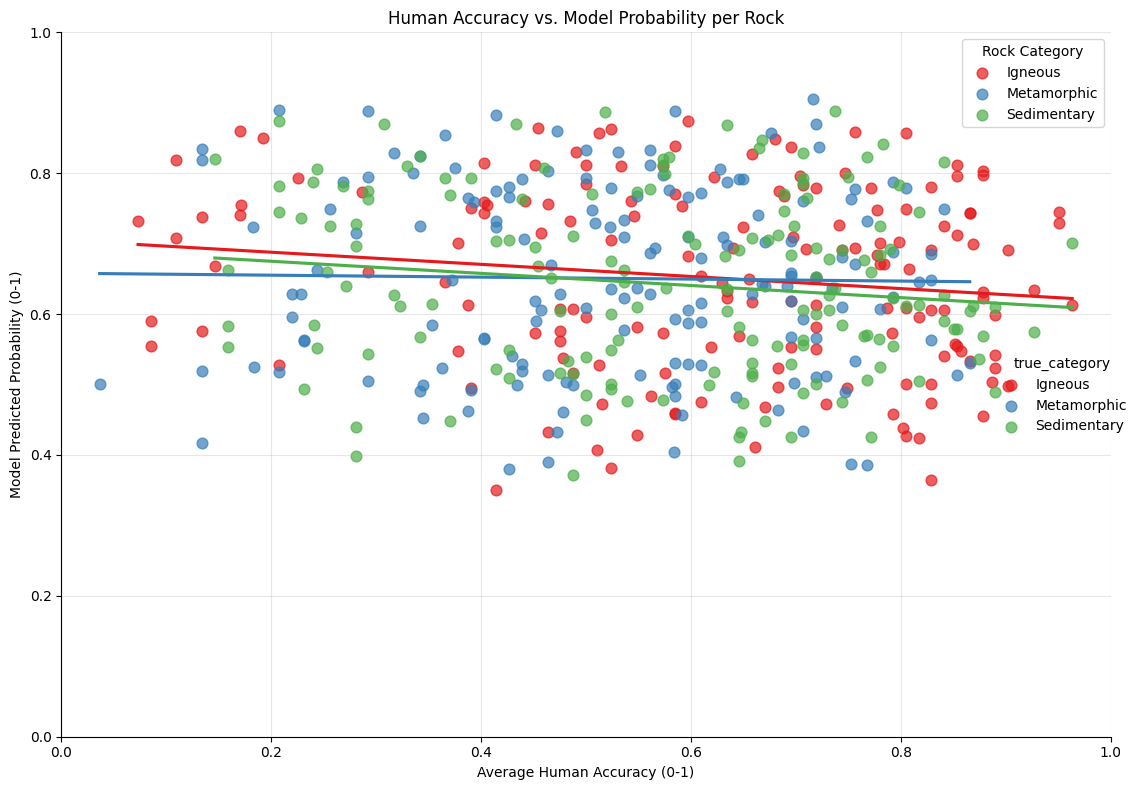

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assume prabability_df is your final dataframe after merging as provided in your code
# Rename columns clearly for plotting convenience
plot_df = prabability_df.rename(columns={
    "cat_correct": "avg_human_accuracy",
    "model_prob": "model_probability",
    "category": "true_category"
})

# Plot
plt.figure(figsize=(8, 6))

# Scatterplot with regression lines (one line per category)
sns.lmplot(
    data=plot_df,
    x='avg_human_accuracy',
    y='model_probability',
    hue='true_category',
    palette='Set1',
    scatter_kws={'s': 60, 'alpha': 0.7},  # dot size and transparency
    height=8,
    aspect=1.25,
    ci=None,  # no confidence interval bands
    markers='o'
)

# Customizing plot aesthetics clearly
plt.title('Human Accuracy vs. Model Probability per Rock', fontsize=12)
plt.xlabel('Average Human Accuracy (0-1)', fontsize=10)
plt.ylabel('Model Predicted Probability (0-1)', fontsize=10)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.legend(title='Rock Category')
plt.tight_layout()

# Display the plot
plt.show()

#### 6.3: Discussion

In [103]:
from scipy.stats import pearsonr
# Compute and print correlations clearly for each category
categories = plot_df['true_category'].unique()

for category in categories:
    subset = plot_df[plot_df['true_category'] == category]
    corr, p_value = pearsonr(subset['avg_human_accuracy'], subset['model_probability'])
    print(f'Category: {category}')
    print(f'  Correlation coefficient: {corr:.3f}')
    print(f'  p-value: {p_value:.4f}')
    if p_value < 0.05:
        print('Correlation is significant (p < 0.05)\n')
    else:
        print('Correlation is not significant (p ≥ 0.05)\n')

# Compute and print correlation clearly for all rocks combined
corr_all, p_value_all = pearsonr(plot_df['avg_human_accuracy'], plot_df['model_probability'])
print('All Rocks Combined:')
print(f'  Correlation coefficient: {corr_all:.3f}')
print(f'  p-value: {p_value_all:.4f}')
if p_value_all < 0.05:
    print('Correlation is significant (p < 0.05)')
else:
    print(' Correlation is not significant (p ≥ 0.05)')

Category: Igneous
  Correlation coefficient: -0.145
  p-value: 0.0680
Correlation is not significant (p ≥ 0.05)

Category: Metamorphic
  Correlation coefficient: -0.019
  p-value: 0.8070
Correlation is not significant (p ≥ 0.05)

Category: Sedimentary
  Correlation coefficient: -0.139
  p-value: 0.0806
Correlation is not significant (p ≥ 0.05)

All Rocks Combined:
  Correlation coefficient: -0.101
  p-value: 0.0267
Correlation is significant (p < 0.05)
